<a href="https://colab.research.google.com/github/nkt1850/Bank_Marketing/blob/main/bank_marketing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv(r"C:\Users\nktun\OneDrive\Documents\GitHub\Bank_Marketing\bank (original dataset)\bank-full.csv", delimiter=';')

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

Understanding the data:  
1 - age (numeric)

   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")
   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   
   5 - default: has credit in default? (binary: "yes","no")
   
   6 - balance: average yearly balance, in euros (numeric)
   
   7 - housing: has housing loan? (binary: "yes","no")
   
   8 - loan: has personal loan? (binary: "yes","no")
   
   # related with the last contact of the current campaign:
   
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
  
  10 - day: last contact day of the month (numeric)
  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12 - duration: last contact duration, in seconds (numeric)
   
   # other attributes:
  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# No missing attributes, this is for splitting and training immediately

In [11]:
# df = pd.read_csv(r"/content/drive/MyDrive/Bank_Marketing-main/Bank_Marketing-main/bank (original dataset)/bank-full.csv", delimiter=';')

In [12]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [13]:
# Selecting X and y, and then perform train test split
X = df.drop(columns=['y', 'duration'])
y = df['y']

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe_job = OneHotEncoder(sparse_output=False) # Instantiate a class of OHE
# Job and Marital should be encoded as OHE because of no inherent ranking, but education does have ranking
encoded_job = ohe_job.fit_transform(X[['job']])
encoded_job_df = pd.DataFrame(encoded_job, columns=ohe_job.get_feature_names_out(['job']))

# Convert the encoded job back to df format to concat to X
ohe_marital = OneHotEncoder(sparse_output=False)
encoded_marital = ohe_marital.fit_transform(X[['marital']])
encoded_marital_df = pd.DataFrame(encoded_marital, columns=ohe_marital.get_feature_names_out(['marital']))

# Concat with the original df
X_encoded = pd.concat([X, encoded_job_df, encoded_marital_df], axis=1)

# Drop the original job column if no longer needed
X_encoded.drop(['job', 'marital'], axis=1, inplace=True)

# Map education and replace housing and loan
education_mapping = {'unknown':0, 'primary':1, 'secondary':2, 'tertiary':3}
X_encoded['education'] = X_encoded['education'].map(education_mapping)

# Mapping binary features
binary_mapping = {'yes':1, 'no':0}
X_encoded['default'] = X_encoded['default'].map(binary_mapping)
X_encoded['loan'] = X_encoded['loan'].map(binary_mapping)
X_encoded['housing'] = X_encoded['housing'].map(binary_mapping)

# Let's drop the month column for now - I wonder if there is a underlying significance to this column
X_encoded.drop(columns='month', inplace=True)

X_encoded.contact.unique() # cardinality = 3
X_encoded.poutcome.unique() # cardinality = 3, as other can be mapped as unknown
X_encoded['poutcome'] = X_encoded['poutcome'].replace('other', 'unknown')

# Now, OHE can be performed on 2 remaining columns: contact & poutcome
ohe_contact = OneHotEncoder(sparse_output=False) # Instantiate a class of OHE
encoded_contact = ohe_contact.fit_transform(X[['contact']])
encoded_contact_df = pd.DataFrame(encoded_contact, columns=ohe_contact.get_feature_names_out(['contact']))

ohe_poutcome = OneHotEncoder(sparse_output=False)
encoded_poutcome = ohe_poutcome.fit_transform(X[['poutcome']])
encoded_poutcome_df = pd.DataFrame(encoded_poutcome, columns=ohe_poutcome.get_feature_names_out(['poutcome']))

# Concat with the original df
X_encoded = pd.concat([X_encoded, encoded_contact_df, encoded_poutcome_df], axis=1)

# Drop the original job column if no longer needed
X_encoded.drop(['contact', 'poutcome'], axis=1, inplace=True)

# Outcome has to be binary as well, not categorical
y = y.map(binary_mapping)


In [14]:
# prompt: show correlation between X and y

import pandas as pd
# Assuming X_encoded and y are defined as in the provided code
correlation_matrix = pd.concat([X_encoded, y], axis=1).corr()
correlation_matrix['y'].sort_values(ascending=False)

y                    1.000000
poutcome_success     0.306788
contact_cellular     0.135873
pdays                0.103621
previous             0.093236
job_retired          0.079245
job_student          0.076897
marital_single       0.063526
balance              0.052838
education            0.051341
job_management       0.032919
poutcome_other       0.031955
age                  0.025155
job_unemployed       0.020390
contact_telephone    0.014042
poutcome_failure     0.009885
job_admin.           0.005637
marital_divorced     0.002772
job_self-employed    0.000855
job_unknown          0.000267
job_technician      -0.008970
job_housemaid       -0.015195
job_entrepreneur    -0.019662
default             -0.022419
job_services        -0.027864
day                 -0.028348
marital_married     -0.060260
loan                -0.068185
job_blue-collar     -0.072083
campaign            -0.073172
housing             -0.139173
contact_unknown     -0.150935
poutcome_unknown    -0.167051
Name: y, d

In [15]:
# Splitting the data with 25 - 75
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y ,
                                   random_state=42,
                                   test_size=0.25,
                                   shuffle=True)
# I use XGBoost so no scaling shall be required

### Great, now that the data has been successfully preprocessed & splitted into training set and testing set

In [16]:
# Get rolling with XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [17]:
# Conversion to DMatrix to ensure operational efficiency from xgb's side
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
# For a classification problem, use XGBClassifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier() # Instantiate model, default params
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test) # predict

In [19]:
# Evaluation of model: Compare y_pred and y_test
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8864
Confusion Matrix:
[[9763  187]
 [1097  256]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      9950
           1       0.58      0.19      0.29      1353

    accuracy                           0.89     11303
   macro avg       0.74      0.59      0.61     11303
weighted avg       0.86      0.89      0.86     11303



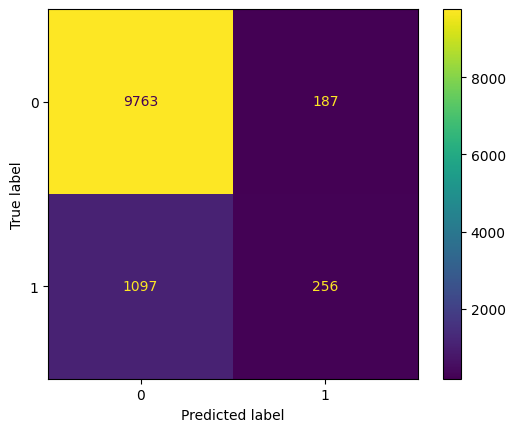

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

In [21]:
y.sum() # 5289 yes over 45k --> There is class imbalance here, I should figure out a way to deal with this

5289

### Pro tip: The key to finding meaningful features: Aggregation

## Implement oversampling to solve the problem: Use another model of xgb classifier to see if there is any diff in recall

In [22]:
# pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42, sampling_strategy='auto') #Instantiate model of random oversampler
X_resampled, y_resampled = ros.fit_resample(X_encoded, y) #Fit the model & resample

# Splitting the data with 25 - 75
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                   random_state=42,
                                   test_size=0.25,
                                   shuffle=True)

xgb_model_resampled = XGBClassifier()
xgb_model_resampled.fit(X_train, y_train)
y_pred = xgb_model_resampled.predict(X_test)

# Evaluation of model WITH RESAMPLING (OVER-SAMPLER): Compare y_pred and y_test
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7952
Confusion Matrix:
[[8035 1914]
 [2175 7837]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      9949
           1       0.80      0.78      0.79     10012

    accuracy                           0.80     19961
   macro avg       0.80      0.80      0.80     19961
weighted avg       0.80      0.80      0.80     19961



Random sampling seems to be doing greater than the previous one

## Hyperparameter tuning using RandomizedSearchCV

In [23]:
# prompt: Perform hyperparameter tuning on the model that uses X_encoded and y

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42) # Use random_state for reproducibility

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model_resampled, # Model trained on resampled data
    param_distributions = param_grid,
                          n_iter=50,  # Number of parameter settings that are sampled
                          scoring='recall', # Optimize for recall
                          cv=5,  # Number of cross-validation folds
                          verbose=1,  # Print progress messages
                          random_state=42, # Use random_state for reproducibility
                          n_jobs=-1 # Utilize all available CPU cores
)


# Perform the hyperparameter search
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train a model with the best hyperparameters
best_xgb_model = XGBClassifier(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.9046
Confusion Matrix:
[[8707 1242]
 [ 662 9350]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      9949
           1       0.88      0.93      0.91     10012

    accuracy                           0.90     19961
   macro avg       0.91      0.90      0.90     19961
weighted avg       0.91      0.90      0.90     19961



In [28]:
import shap

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)

100%|===================| 19905/19961 [04:38<00:00]        

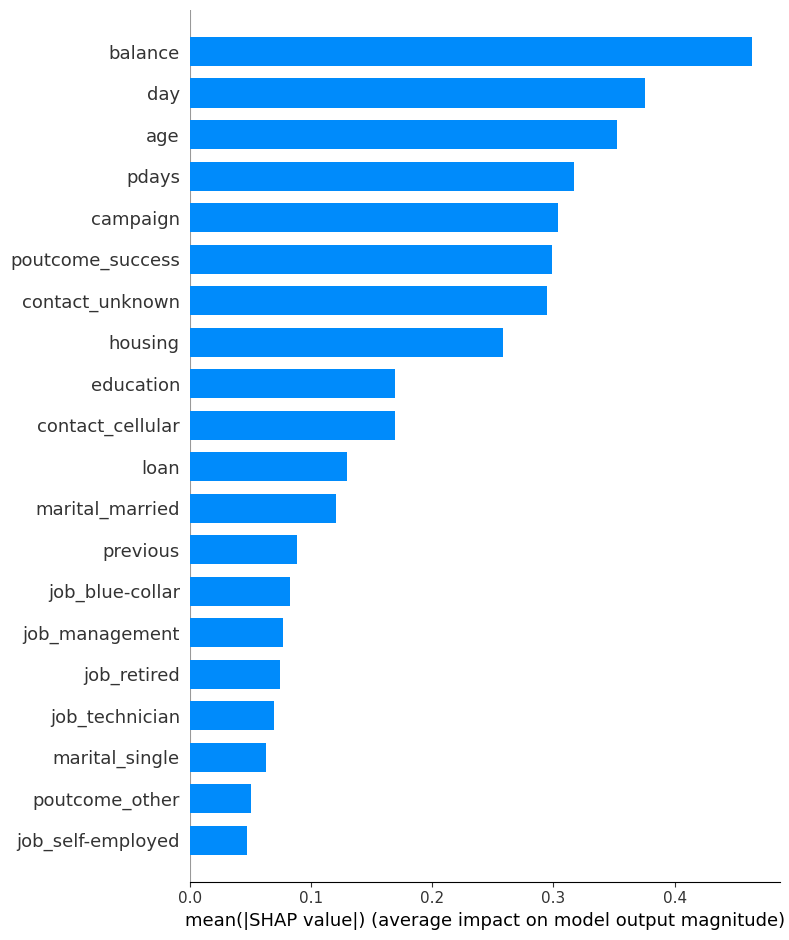

In [29]:
# Summarize the effects of all the features (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Test with a brand new data set: bank.csv


In [30]:
# df = pd.read_csv(r"/content/drive/MyDrive/Bank_Marketing-main/Bank_Marketing-main/bank (original dataset)/bank.csv", delimiter=';')
df = pd.read_csv(r"C:\Users\nktun\OneDrive\Documents\GitHub\Bank_Marketing\bank (original dataset)\bank.csv", delimiter=';')

In [31]:
# Use the pipeline above to parse the data for this dataset
# Selecting X and y, and then perform train test split
X = df.drop(columns=['y', 'duration'])
y = df['y']

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe_job = OneHotEncoder(sparse_output=False) # Instantiate a class of OHE
# Job and Marital should be encoded as OHE because of no inherent ranking, but education does have ranking
encoded_job = ohe_job.fit_transform(X[['job']])
encoded_job_df = pd.DataFrame(encoded_job, columns=ohe_job.get_feature_names_out(['job']))

# Convert the encoded job back to df format to concat to X
ohe_marital = OneHotEncoder(sparse_output=False)
encoded_marital = ohe_marital.fit_transform(X[['marital']])
encoded_marital_df = pd.DataFrame(encoded_marital, columns=ohe_marital.get_feature_names_out(['marital']))

# Concat with the original df
X_encoded = pd.concat([X, encoded_job_df, encoded_marital_df], axis=1)

# Drop the original job column if no longer needed
X_encoded.drop(['job', 'marital'], axis=1, inplace=True)

# Map education and replace housing and loan
education_mapping = {'unknown':0, 'primary':1, 'secondary':2, 'tertiary':3}
X_encoded['education'] = X_encoded['education'].map(education_mapping)

# Mapping binary features
binary_mapping = {'yes':1, 'no':0}
X_encoded['default'] = X_encoded['default'].map(binary_mapping)
X_encoded['loan'] = X_encoded['loan'].map(binary_mapping)
X_encoded['housing'] = X_encoded['housing'].map(binary_mapping)

# Let's drop the month column for now - I wonder if there is a underlying significance to this column
X_encoded.drop(columns='month', inplace=True)

X_encoded.contact.unique() # cardinality = 3
X_encoded.poutcome.unique() # cardinality = 3, as other can be mapped as unknown
X_encoded['poutcome'] = X_encoded['poutcome'].replace('other', 'unknown')

# Now, OHE can be performed on 2 remaining columns: contact & poutcome
ohe_contact = OneHotEncoder(sparse_output=False) # Instantiate a class of OHE
encoded_contact = ohe_contact.fit_transform(X[['contact']])
encoded_contact_df = pd.DataFrame(encoded_contact, columns=ohe_contact.get_feature_names_out(['contact']))

ohe_poutcome = OneHotEncoder(sparse_output=False)
encoded_poutcome = ohe_poutcome.fit_transform(X[['poutcome']])
encoded_poutcome_df = pd.DataFrame(encoded_poutcome, columns=ohe_poutcome.get_feature_names_out(['poutcome']))

# Concat with the original df
X_encoded = pd.concat([X_encoded, encoded_contact_df, encoded_poutcome_df], axis=1)

# Drop the original job column if no longer needed
X_encoded.drop(['contact', 'poutcome'], axis=1, inplace=True)

# Outcome has to be binary as well, not categorical
y = y.map(binary_mapping)


In [32]:
# Make predictions on the unseen dataset (bank.csv)
y_pred = best_xgb_model.predict(X_encoded)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

Accuracy: 0.9310
Confusion Matrix:
[[3720  280]
 [  32  489]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4000
           1       0.64      0.94      0.76       521

    accuracy                           0.93      4521
   macro avg       0.81      0.93      0.86      4521
weighted avg       0.95      0.93      0.94      4521

